In [1]:
import numpy as np
import cv2
from PIL import Image
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')


In [2]:
SIZE = 10           # 游戏区域的大小
EPISODES = 30000    # 局数
SHOW_EVERY = 3000   # 定义每隔多少局展示一次图像

FOOD_REWARD = 25      # agent获得食物的奖励
ENEMY_PENALITY = 300  # 遇上对手的惩罚
MOVE_PENALITY = 1     # 每移动一步的惩罚

epsilon = 0.6
EPS_DECAY = 0.9998
DISCOUNT = 0.95
LEARNING_RATE = 0.1

q_table = None
# 设定三个部分的颜色分别是蓝、绿、红
d = {1:(255,0,0), # blue
     2:(0,255,0), # green
     3:(0,0,255)} # red
PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3


In [3]:
class Cube:
    def __init__(self): # 随机初始化位置坐标
        self.x = np.random.randint(0, SIZE-1)
        self.y = np.random.randint(0, SIZE-1)
    def __str__(self):
        return f'{self.x},{self.y}'
    def __sub__(self, other):
        return (self.x-other.x,self.y- other.y)
    def action(self,choise):
        if choise == 0:
            self.move(x=1,y=1)
        elif choise == 1:
            self.move(x=-1, y=1)
        elif choise == 2:
            self.move(x=1, y=-1)
        elif choise == 3:
            self.move(x=-1, y=-1)
    def move(self,x=False, y=False):
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        if self.x< 0:
            self.x = 0
        if self.x> SIZE -1:
            self.x = SIZE-1
        if self.y< 0:
            self.y = 0
        if self.y> SIZE -1:
            self.y = SIZE-1


In [4]:
# 初始化Q表格
q_table = None
if q_table is None:   # 如果没有实现提供，就随机初始化一个Q表格
    q_table = {}
    for x1 in range(-SIZE+1,SIZE):
        for y1 in range(-SIZE + 1, SIZE):
            for x2 in range(-SIZE + 1, SIZE):
                for y2 in range(-SIZE + 1, SIZE):
                    q_table[((x1,y1),(x2,y2))] = [np.random.randint(-5,0) for i in range(4)]
else:                # 提供了，就使用提供的Q表格
    with open(q_table,'rb') as f:
        q_table= pickle.load(f)

In [8]:
episode_rewards = []
for episode in range(EPISODES):
    player = Cube()
    food = Cube()
    enemy = Cube()

    if episode % SHOW_EVERY == 0:
        print('episode ',episode,'  epsilon:',epsilon)
        print('mean_reward:',np.mean(episode_rewards[-SHOW_EVERY:]))
        show = True
    else:
        show = False

    episode_reward = 0
    for i in range(200):
        obs = (player - food,player - enemy)
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs])   # 选择Q值最高的动作，来进行开发
        else:
            action = np.random.randint(0,4)    # 随机选择一个动作，进行探索

        # print("player的位置：",player)
        # print("player的观测：",obs)
        # print("player的动作：",action)
        player.action(action)              # 智能体执行动作
        food.move()
        enemy.move()

        # 奖励
        if player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        elif player.x == enemy.x and player.y == enemy.y:
            reward = - ENEMY_PENALITY
        else:
            reward = - MOVE_PENALITY
        # print('reward:',reward)

        # 更新Q表格
        current_q = q_table[obs][action]            # 当前动作、状态对应的Q值
        # print('current_q:',current_q)
        new_obs = (player-food,player-enemy)        # 动作之后新的状态
        # print('new_obs:',new_obs)
        max_future_q = np.max(q_table[new_obs])     # 新的状态下，最大的Q值
        # print('max_future_q:',max_future_q)
        # print('')
        if reward ==FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1-LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT* max_future_q)
        q_table[obs][action] = new_q

        # 图像显示
        if show:
            env = np.zeros((SIZE,SIZE,3),dtype=np.uint8)
            env[food.x][food.y] = d[FOOD_N]
            env[player.x][player.y] = d[PLAYER_N]
            env[enemy.x][enemy.y] = d[ENEMY_N]
            img = Image.fromarray(env,'RGB')
            img = img.resize((800,800))
            cv2.imshow('',np.array(img))
            if reward == FOOD_REWARD or reward == -ENEMY_PENALITY:
                 if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        episode_reward += reward

        if reward == FOOD_REWARD or reward ==ENEMY_PENALITY:
            break
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY


C:\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode  0   epsilon: 0.0014863591039423116
mean_reward: nan
episode  3000   epsilon: 0.0008156822227294347
mean_reward: -15.599
episode  6000   epsilon: 0.00044762903305946587
mean_reward: -12.092666666666666
episode  9000   epsilon: 0.0002456492806319455
mean_reward: -12.174666666666667
episode  12000   epsilon: 0.00013480709386197562
mean_reward: -12.760666666666667
episode  15000   epsilon: 7.397926225861729e-05
mean_reward: -10.788666666666666
episode  18000   epsilon: 4.0598243664631156e-05
mean_reward: -9.337333333333333
episode  21000   epsilon: 2.2279451542662007e-05
mean_reward: -9.385
episode  24000   epsilon: 1.2226488543253467e-05
mean_reward: -9.814333333333334
episode  27000   epsilon: 6.7096365371500425e-06
mean_reward: -9.639


27001


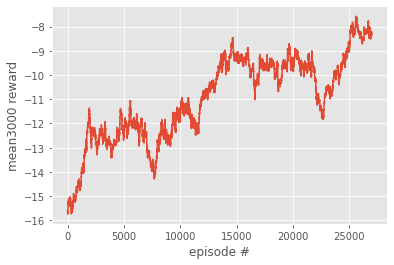

In [9]:
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY,mode='valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean{SHOW_EVERY} reward')
plt.show()

In [10]:
with open(f'qtable_{int(time.time())}.pickle','wb') as f:
    pickle.dump(q_table,f)


















